In [1]:
!pip install librosa
!pip install pandas
!pip install scikit-learn

In [2]:
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import joblib

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [4]:
X_train=torch.load('Data/X_train_10s_all_2626_100.pt').float()
Y_train=torch.load('Data/Y_train_10s_all_2626_100.pt').float()
X_val=torch.load('Data/X_val_10s_all_2626_100.pt').float()
Y_val=torch.load('Data/Y_val_10s_all_2626_100.pt').float()

In [5]:
X_train.shape

torch.Size([5045, 10, 53, 100])

In [6]:
def CM(model,X_val,Y_val):
    YY=Y_val.cpu().detach().numpy().copy()
    YYY=YY.copy()
    YY0=YY[:,0].copy()
    YY1=YY[:,1].copy()
    
    YH=model(X_val.float().to(device))
    YH = YH.cpu().detach().numpy()
    YYH=YH.copy()
    YH0=YH[:,0].copy()
    YH1=YH[:,1].copy()
    
    for i in range(YY.shape[0]):
            if (YY[i,0]<-0) & (YY[i,1]<-0) :
                YYY[i,0] = 1 #"low_a & low_v"
            elif (YY[i,0]>0) & (YY[i,1]<-0) :
                YYY[i,0]= 2 #"high_a & low_v"
            elif (YY[i,0]<-0) & (YY[i,1]>0) :
                YYY[i,0]=3 #"low_a & high_v"
            elif (YY[i,0]>0) & (YY[i,1]>0) :
                YYY[i,0]= 4 #"high_a & high_v"
            else:  YYY[i,0]= 5
    for i in range(YH.shape[0]):
            if (YH[i,0]<-0) & (YH[i,1]<-0) :
                YYH[i,0]=1 #"low_a & low_v"
            elif (YH[i,0]>0) & (YH[i,1]<-0) :
                YYH[i,0]=2 #"high_a & low_v"
            elif (YH[i,0]<-0) & (YH[i,1]>0) :
                YYH[i,0]=3 #"low_a & high_v"
            elif (YH[i,0]>0) & (YH[i,1]>0) :
                YYH[i,0]=4 #"high_a & high_v"
            else: YYH[i,0]=5
                
    for i in range(YY0.shape[0]):
            if (YY0[i]<-0) :
                YY0[i] = 0 #"low_a"
            elif (YY0[i]>0) :
                YY0[i]= 1 #"high_a"
            else: YY0[i]= 2
    for i in range(YY1.shape[0]):
            if (YY1[i]<-0) :
                YY1[i] = 0 #"low_v"
            elif (YY1[i]>0) :
                YY1[i]= 1 #"high_v"
            else: YY1[i] = 2
                
    for i in range(YH0.shape[0]):
            if (YH0[i]<-0) :
                YH0[i] = 0 #"low_a"
            elif (YH0[i]>0) :
                YH0[i]= 1 #"high_a"
            else: YH0[i] = 2
    
    for i in range(YH1.shape[0]):
            if (YH1[i]<-0) :
                YH1[i] = 0 #"low_v"
            elif (YH1[i]>0) :
                YH1[i]= 1 #"high_v"
            else: YH1[i] = 2
    
    
    cm0 = confusion_matrix(YY0.reshape(-1,1),YH0.reshape(-1,1))
    row_sums0 = cm0.sum(axis=1, keepdims=True)
    percentage0 = (cm0 / row_sums0) * 100
    
    cm1 = confusion_matrix(YY1.reshape(-1,1),YH1.reshape(-1,1))
    row_sums1 = cm1.sum(axis=1, keepdims=True)
    percentage1 = (cm1 / row_sums1) * 100
    
    cm = confusion_matrix(YYY[:,0].reshape(-1,1),YYH[:,0].reshape(-1,1))
    row_sums = cm.sum(axis=1, keepdims=True)
    percentage = (cm / row_sums) * 100
    # 可视化混淆矩阵
    fig, (ax0, ax1,ax2) = plt.subplots(1, 3, figsize=(20, 8))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=percentage, display_labels=["-a & -v", "+a & -v", "+a & +v", "-a & +v"])
    disp.plot(ax=ax0,cmap=plt.cm.Blues)
    disp0 = ConfusionMatrixDisplay(confusion_matrix=percentage0, display_labels=["-a", "+a"])
    disp0.plot(ax=ax1, cmap=plt.cm.Blues)  # 指定绘图的轴
    disp1 = ConfusionMatrixDisplay(confusion_matrix=percentage1, display_labels=["-v","+v"])
    disp1.plot(ax=ax2, cmap=plt.cm.Blues)  # 指定绘图的轴
    
    plt.show()

In [7]:
class DynamicPCALayer_Seq(nn.Module):
    def __init__(self, n_components):
        super(DynamicPCALayer_Seq, self).__init__()
        self.n_components = n_components
        self.pca = None
    def fit(self, X):
        self.pca = PCA()#n_components=self.n_components)
        self.pca.fit(X)
        cumulative_variance = np.cumsum(self.pca.explained_variance_ratio_)
        I90=np.searchsorted(cumulative_variance, 0.90)
        I95=np.searchsorted(cumulative_variance, 0.95)
        I98=np.searchsorted(cumulative_variance, 0.98)
        cumulative_explained_variance = np.sum(self.pca.explained_variance_ratio_[:self.n_components])
        print(f"90% : {I90}, 95% : {I95}, 98% : {I98}, now:{cumulative_explained_variance}")
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X)
        
    def forward(self, X):
        batch_size, seq_len, feature_dim = X.size()
        #batch_size, feature_dim = X.size()
        X_flat = X.view(-1, feature_dim)
        if self.pca is None:
            self.fit(X_flat.cpu().detach().numpy())
            
        
        X_pca = self.pca.transform(X_flat.cpu().detach().numpy())
        X_pca = torch.from_numpy(X_pca).float().to(X.device)
        X_pca = X_pca.view(batch_size, seq_len, -1)
        #X_pca = X_pca.view(batch_size, -1)
        return X_pca

In [8]:
class DynamicPCALayer_Non_Seq(nn.Module):
    def __init__(self, n_components):
        super(DynamicPCALayer_Non_Seq, self).__init__()
        self.n_components = n_components
        self.pca = None
    def fit(self, X):
        self.pca = PCA()#n_components=self.n_components)
        self.pca.fit(X)
        cumulative_variance = np.cumsum(self.pca.explained_variance_ratio_)
        I90=np.searchsorted(cumulative_variance, 0.90)
        I95=np.searchsorted(cumulative_variance, 0.95)
        I98=np.searchsorted(cumulative_variance, 0.98)
        cumulative_explained_variance = np.sum(self.pca.explained_variance_ratio_[:self.n_components])
        print(f"90% : {I90}, 95% : {I95}, 98% : {I98}, now:{cumulative_explained_variance}")
        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(X)
        
    def forward(self, X):
        #batch_size, seq_len, feature_dim = X.size()
        batch_size, feature_dim = X.size()
        X_flat = X.view(-1, feature_dim)
        if self.pca is None:
            self.fit(X_flat.cpu().detach().numpy())
            
        
        X_pca = self.pca.transform(X_flat.cpu().detach().numpy())
        X_pca = torch.from_numpy(X_pca).float().to(X.device)
        #X_pca = X_pca.view(batch_size, seq_len, -1)
        X_pca = X_pca.view(batch_size, -1)
        return X_pca

In [14]:
import torch
import torch.nn as nn
import joblib

class RCNN(nn.Module):
    def __init__(self):
        super(RCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=53, out_channels=48, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv1d(in_channels=48, out_channels=64, kernel_size=4, stride=1, padding=0)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2, stride=1, padding=0)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=2, stride=1, padding=0)

        self.maxpooling4 = nn.MaxPool1d(kernel_size=4, stride=4, padding=0)
        self.maxpooling3 = nn.MaxPool1d(kernel_size=3, stride=3, padding=0)
        self.maxpooling2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.flatten = nn.Flatten(start_dim=1)
        
        self.pca = DynamicPCALayer_Seq(72)
        #self.GRU = nn.GRU(input_size=64, hidden_size=128, num_layers=5, batch_first=True)
        self.LSTM = nn.LSTM(input_size=72, hidden_size=256, num_layers=10, batch_first=True)
       
        #self.pca2 = DynamicPCALayer_Non_Seq(32)
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 256)
        #self.fc3 = nn.Linear(256, 256)
        #self.fc4 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 2)

        self.relu = nn.ReLU()
        self.drop = torch.nn.Dropout(0.5)

    def forward(self, x, h=None):
        X11=[]
        for i in range(x.shape[0]):
                xx=x[i,:,:,:]
                xx=self.conv1(xx)
                xx=self.maxpooling4(xx)
                xx=self.conv2(xx)
                xx=self.maxpooling3(xx)
                xx=self.conv3(xx)
                xx=self.maxpooling2(xx)
                xx=self.conv4(xx)
                xx=self.maxpooling2(xx)

                xx=self.flatten(xx)
                X11.append(xx)
        X=torch.stack(X11,dim=0).float()
        X = self.pca(X)
        #x,_ = self.GRU(X)
        x,_ = self.LSTM(X)
        x=x[:, -1, :]
        #x=self.pca2(x)

        #x = torch.cat((x,x_f),dim=2)
        
        x = self.drop(x)
        x1 = self.fc1(x)
        x1 = self.relu(x1)
        x1 = self.fc2(x1)
        #x1 = self.relu(x1)
        #x1 = self.fc3(x1)
        #x1 = self.relu(x1)
        #x1 = self.fc4(x1)
        x1 = self.relu(x1)
        x = self.fc5(x1)
        return x

    def save_model(self, model_path, pca_paths):
        torch.save(self.state_dict(), model_path)
        joblib.dump(self.pca.pca, pca_paths[0])
        #joblib.dump(self.pca2.pca, pca_paths[1])
        #joblib.dump(self.pca3.pca, pca_paths[2])

    def load_model(self, model_path, pca_paths):
        self.load_state_dict(torch.load(model_path))
        self.pca.pca = joblib.load(pca_paths[0])
        #self.pca2.pca = joblib.load(pca_paths[1])
        #self.pca3.pca = joblib.load(pca_paths[2])


In [15]:
def evaluation(model, X, Y):
    YY=Y
    YH=model(X)

    YY_a=YY[:,0]
    YY_v=YY[:,1]
    YH_a=YH[:,0]
    YH_v=YH[:,1]
    m_d = torch.mean((YY - YH) ** 2)
    #m_d = torch.mean(torch.sqrt((YY_a - YH_a) ** 2 + (YY_v - YH_v) ** 2))
    mse_a = torch.mean((YY_a - YH_a) ** 2)
    rmse_a = torch.sqrt(mse_a)
    mse_v = torch.mean((YY_v - YH_v) ** 2)
    rmse_v = torch.sqrt(mse_v)
    
    mean_YY_a = torch.mean(YY_a)
    mean_YH_a = torch.mean(YH_a)
    
    covariance_a = torch.mean((YY_a - mean_YY_a) * (YH_a - mean_YH_a))
    std_YY_a = torch.std(YY_a)
    std_YH_a = torch.std(YH_a)
    
    pcc_a = covariance_a / (std_YY_a * std_YH_a)
    
    mean_YY_v = torch.mean(YY_v)
    mean_YH_v = torch.mean(YH_v)
    
    covariance_v = torch.mean((YY_v - mean_YY_v) * (YH_v - mean_YH_v))
    std_YY_v = torch.std(YY_v)
    std_YH_v = torch.std(YH_v)
    
    pcc_v = covariance_v / (std_YY_v * std_YH_v)


    return m_d.item(),pcc_a.item(),pcc_v.item(),rmse_a.item(),rmse_v.item()

In [16]:
def evaluation_F(model, X, Y):
    YY=Y
    YH=model(X)

    YY_a=YY[:,0]
    YY_v=YY[:,1]
    YH_a=YH[:,0]
    YH_v=YH[:,1]
    m_d = torch.mean((YY - YH) ** 2)
    #m_d = torch.mean(torch.sqrt((YY_a - YH_a) ** 2 + (YY_v - YH_v) ** 2))
    mse_a = torch.mean((YY_a - YH_a) ** 2)
    rmse_a = torch.sqrt(mse_a)
    mse_v = torch.mean((YY_v - YH_v) ** 2)
    rmse_v = torch.sqrt(mse_v)
    
    mean_YY_a = torch.mean(YY_a)
    mean_YH_a = torch.mean(YH_a)
    
    covariance_a = torch.mean((YY_a - mean_YY_a) * (YH_a - mean_YH_a))
    std_YY_a = torch.std(YY_a)
    std_YH_a = torch.std(YH_a)
    
    pcc_a = covariance_a / (std_YY_a * std_YH_a)
    
    mean_YY_v = torch.mean(YY_v)
    mean_YH_v = torch.mean(YH_v)
    
    covariance_v = torch.mean((YY_v - mean_YY_v) * (YH_v - mean_YH_v))
    std_YY_v = torch.std(YY_v)
    std_YH_v = torch.std(YH_v)
    
    pcc_v = covariance_v / (std_YY_v * std_YH_v)    
    n = Y.shape[0]
    se_rmse_a = rmse_a / torch.sqrt(torch.tensor(n, dtype=torch.float32))
    se_rmse_v = rmse_v / torch.sqrt(torch.tensor(n, dtype=torch.float32))

    se_pcc_a = torch.sqrt((1 - pcc_a ** 2) / (n - 2))
    se_pcc_v = torch.sqrt((1 - pcc_v ** 2) / (n - 2))

    return rmse_v.item(),se_rmse_v.item(),pcc_v.item(),se_pcc_v.item(),rmse_a.item(),se_rmse_a.item(),pcc_a.item(),se_pcc_a.item()

In [17]:
# 模型初始化
def init_weights(m):
  if type(m)== torch.nn.Linear or type(m)== torch.nn.Conv1d :
    torch.nn.init.xavier_uniform_(m.weight)
model = RCNN().to(device)
model.apply(init_weights)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001,betas=(0.8,0.8))

In [18]:
epochs = 2000
batch_size = 256
epoch_losses=[]
#epoch_T_MD = []
epoch_V_MD = []

#epoch_T_PCC_A=[]
#epoch_T_PCC_V=[]
#epoch_T_RMSE_A=[]
#epoch_T_RMSE_V=[]

epoch_V_PCC_A=[]
epoch_V_PCC_V=[]
epoch_V_RMSE_A=[]
epoch_V_RMSE_V=[]

best_test_acc = 1000
patience = 50
improvement_threshold = 0
wait = 0
for epoch in range(epochs):
    model.train()
    #h = None
    total_loss = 0
    for i in range(int(X_train.shape[0]//batch_size)):
        start_index = i * batch_size
        end_index = start_index + batch_size
        inputs = X_train[start_index:end_index,:, :].to(device)
        #inputs_F = X_F_train[start_index:end_index,:,:].to(device)
        targets = Y_train[start_index:end_index,:].to(device)
        outputs = model(inputs)#,inputs_F)
        # 前向传播
        loss = criterion(outputs, targets)
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #h = h.detach()
        total_loss += loss.item()
    loss1= total_loss/int(X_train.shape[0]//batch_size)
    with torch.no_grad():
        model.eval()
        #T_MD,T_PCC_A,T_PCC_V,T_RMSE_A,T_RMSE_V=evaluation(model,X_train.to(device),Y_train.to(device))
        V_MD,V_PCC_A,V_PCC_V,V_RMSE_A,V_RMSE_V=evaluation(model,X_val.to(device),Y_val.to(device))
        #T_train, Ta_train, Tv_train= evaluation(model,X_train.to(device),Y_train.to(device))
        #T_val,Ta_val,Tv_val= evaluation(model,X_val.to(device),Y_val.to(device))
    
    epoch_losses.append(loss1)
    
    #epoch_T_MD.append(T_MD)
    epoch_V_MD.append(V_MD)
    
    #epoch_T_PCC_A.append(T_PCC_A)
    #epoch_T_PCC_V.append(T_PCC_V)
    #epoch_T_RMSE_A.append(T_RMSE_A)
    #epoch_T_RMSE_V.append(T_RMSE_V)
    
    epoch_V_PCC_A.append(V_PCC_A)
    epoch_V_PCC_V.append(V_PCC_V)
    epoch_V_RMSE_A.append(V_RMSE_A)
    epoch_V_RMSE_V.append(V_RMSE_V)
    current_test_acc = epoch_V_MD[-1]
    if current_test_acc < best_test_acc - improvement_threshold:
        best_test_acc = current_test_acc
        wait = 0
        model_path = 'best_model_10s_100.pth'
        pca_paths = ['pca1_10s_100.pkl']#,'pca2_10s_100.pkl']#, 'pca3.pkl']
        model.save_model(model_path, pca_paths)

    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping triggered at epoch {epoch + 1}.')
            print(f'The Testing accuracy of the best model is: {best_test_acc}.')
            break
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss1:.4f},V_MD: {V_MD:.5f}[({V_RMSE_A:.2f},{V_RMSE_V:.2f}),({V_PCC_A:.2f},{V_PCC_V:.2f})],best_md={best_test_acc:.5f},wait={wait}')

90% : 8, 95% : 24, 98% : 78, now:0.9781779050827026
Epoch 1/2000, Loss: 0.0637,V_MD: 0.04441[(0.21,0.21),(0.66,0.43)],best_md=0.04441,wait=0
Epoch 2/2000, Loss: 0.0421,V_MD: 0.03833[(0.19,0.20),(0.75,0.49)],best_md=0.03833,wait=0
Epoch 3/2000, Loss: 0.0347,V_MD: 0.03472[(0.18,0.19),(0.79,0.55)],best_md=0.03472,wait=0
Epoch 4/2000, Loss: 0.0296,V_MD: 0.03248[(0.17,0.19),(0.80,0.58)],best_md=0.03248,wait=0
Epoch 5/2000, Loss: 0.0266,V_MD: 0.03140[(0.17,0.19),(0.80,0.60)],best_md=0.03140,wait=0
Epoch 6/2000, Loss: 0.0244,V_MD: 0.03222[(0.17,0.19),(0.80,0.61)],best_md=0.03140,wait=1
Epoch 7/2000, Loss: 0.0238,V_MD: 0.03602[(0.18,0.20),(0.82,0.59)],best_md=0.03140,wait=2
Epoch 8/2000, Loss: 0.0226,V_MD: 0.02943[(0.16,0.18),(0.83,0.62)],best_md=0.02943,wait=0
Epoch 9/2000, Loss: 0.0205,V_MD: 0.02879[(0.15,0.18),(0.83,0.63)],best_md=0.02879,wait=0
Epoch 10/2000, Loss: 0.0192,V_MD: 0.02808[(0.16,0.18),(0.83,0.64)],best_md=0.02808,wait=0
Epoch 11/2000, Loss: 0.0182,V_MD: 0.02932[(0.16,0.18),(0.

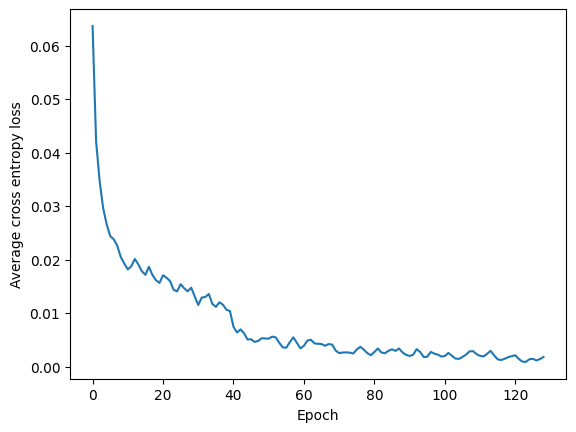

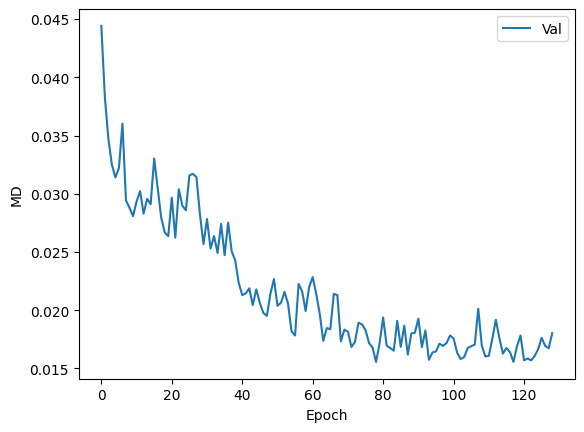

In [19]:
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Average cross entropy loss')
plt.show()
#plt.plot(epoch_T_MD,label="Train")
plt.plot(epoch_V_MD,label="Val")

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MD')
#plt.ylim(0, 100)
plt.show()

In [20]:
model.load_model(model_path, pca_paths)
model.eval()
R= evaluation_F(model,X_val.to(device),Y_val.to(device))
RR = tuple(round(num, 3) for num in R)
print(RR)

(0.129, 0.003, 0.834, 0.012, 0.12, 0.003, 0.901, 0.009)


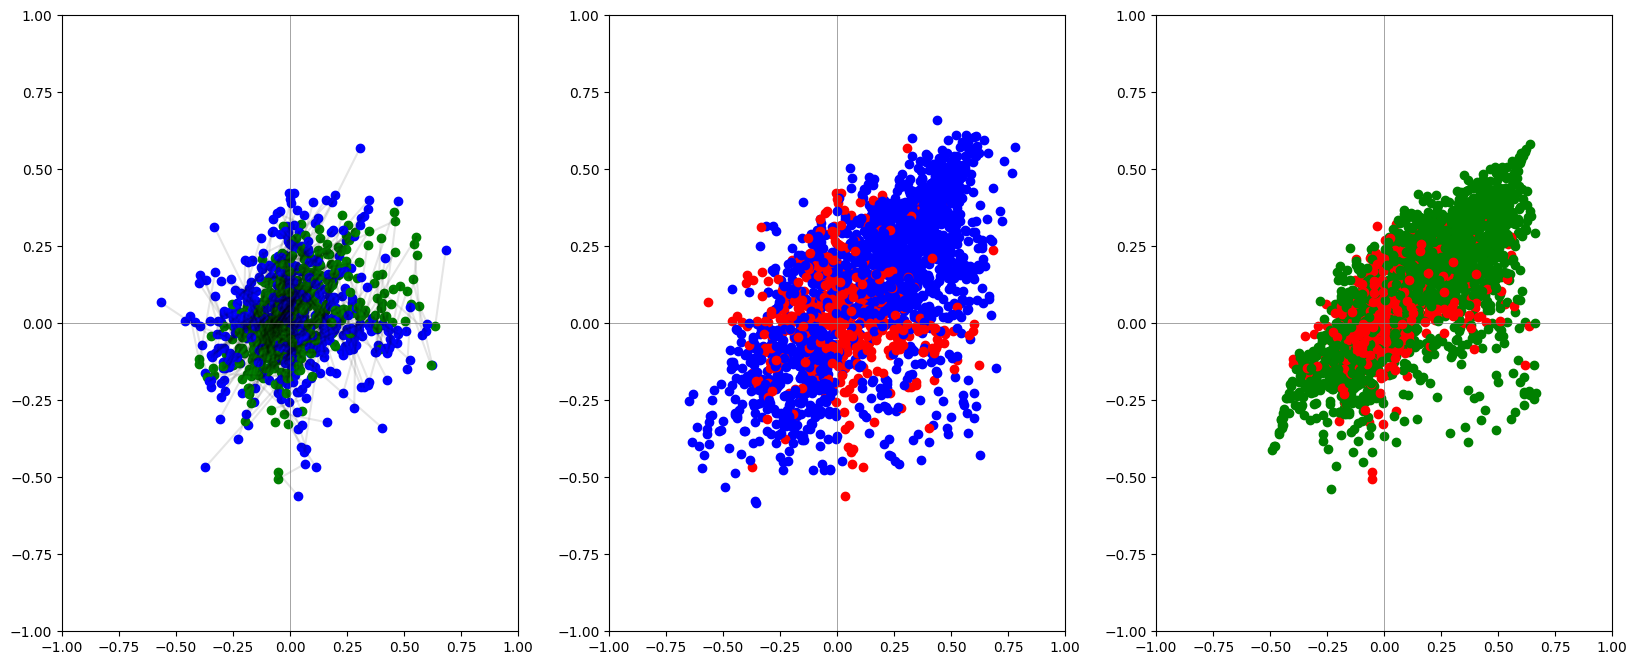

In [21]:
YY = Y_val.cpu().detach().numpy()
YH = model(X_val.float().to(device))
YH = YH.cpu().detach().numpy()

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 8))

for a in range(Y_val.shape[0]):
        if (YY[a,  0]>0) != (YH[a, 0]>0) or (YY[a,  1]>0) != (YH[a, 1]>0):
            ax0.plot([YY[a,  0], YH[a, 0]], [YY[a, 1], YH[a, 1]], c='black', alpha=0.1)
            ax0.scatter(YY[a,  0], YY[a,  1], c='b')
            ax0.scatter(YH[a,  0], YH[a,  1], c='g')

            ax1.scatter(YY[a,  0], YY[a, 1], c='r')
            ax2.scatter(YH[a,  0], YH[a, 1], c='r')
        else:
            ax1.scatter(YY[a,  0], YY[a, 1], c='b')
            ax2.scatter(YH[a,  0], YH[a, 1], c='g')

for ax in [ax0, ax1, ax2]:
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)

plt.show()